### Quantum state tomography by on-line measuring with IC&SIC-POVM and MMW method
(toy example with no noise)

The problem of state tomography is estimating the state of the quantum system that is fully described by its density matrix $\rho$ from the measuarements with possible outcomes $\{0, 1\}$ of some observables $\{E_i\}$ where the probability to obtain "1" when measure the observable $E_i$ is $p(m) = \operatorname{Tr}(E_m \rho)$

In [1]:
using LinearAlgebra
using Statistics
using PyPlot

Function to generate an random $n \times n$ desity matrix we want to indentify (consider unknown)

In our toy example consider $2 \times 2$ desity matrix:
\begin{align}
  \rho = 
        \left(
        \begin{array}{ccccc}
            \rho_{00}   &   \rho_{01}  \\
            \rho_{01}^*  &  \rho_{11} \\
        \end{array}
        \right)
\end{align}

In [2]:
function ρᵣₐₙ(n)
    # return a random density matrix
    ρ = -1 .+ 2 * rand(n, n) 
    ρ += im * (-1 .+ 2 * rand(n, n))  
    ρ = ρ * ρ'
    Hermitian(ρ / tr(ρ))
end
ρᵣₐₙ(2)

2×2 Hermitian{ComplexF64, Matrix{ComplexF64}}:
   0.331156+0.0im        -0.0157883-0.0938055im
 -0.0157883+0.0938055im    0.668844+0.0im

   Any density matrix could be expressed as linear combintion of Pauli matrices:

$ \rho = \frac{\operatorname{Tr}(\rho)I + \operatorname{Tr}(X\rho)X +
\operatorname{Tr}(Y\rho)Y +\operatorname{Tr}(Z\rho)Z}{2}$

To perform tomography we can potentially use Pauli matrices
\begin{align}
  \sigma_1 = I =  \begin{pmatrix}
            1   &  0 \\
            0   &  1 \\
       \end{pmatrix}
       \quad
  \sigma_2 = X =  \begin{pmatrix}
            0   &  1 \\
            1   &  0 \\
       \end{pmatrix}
       \quad
  \sigma_3 = Y =  \begin{pmatrix}
            0   &  -i \\
            i   &  0 \\
       \end{pmatrix}
       \quad 
  \sigma_4 = Z =  \begin{pmatrix}
            1   &   0 \\
            0   &  -1 \\
       \end{pmatrix}
       \quad   
\end{align}



In [3]:
σ₁ = [1 0; 0 1]
σ₂ = [0 1; 1 0]
σ₃ = [0 -im; im 0]
σ₄ = [1 0; 0 -1];

But measuring with Pauli matrices is not POVM!

In [4]:
λₓ = eigvals(σ₃)
σ₁ + σ₂ + σ₃ + σ₄ 

2×2 Matrix{Complex{Int64}}:
 2+0im  1-1im
 1+1im  0+0im

We can use fidelity to check the similarity of quantum states
$F = \left( \operatorname{Tr} \sqrt{\sqrt{\rho} \omega \sqrt{\rho}} \right)^2$

In [5]:
function fidelity(ρ, 𝜔)
    s = sqrt(sqrt(ρ)*𝜔*sqrt(ρ))
    return abs(tr(s)^2)
end 
ρ₁ = ρᵣₐₙ(2)
ρ₂ = [1/2 0; 0 1/2]
println(fidelity(ρ₁, ρ₂))
println(fidelity(ρ₁, ρ₁))

0.8871121087623206
0.9999999999999973


To perform quantun state tomography we need to measure quantum system with <br> a set of Positive operator-valued measure (POVM) operators $\{E_i\}$ that should be <b> informationally complete (IC)</b>. 

### POVM Definition

A POVM over a $d$-dimensional Hilbert space $\mathcal{H}$ is a set of $m$ positive-semidefinite operators operators $E = \{E_i\ | i \in \{1,...,m\} \}$ on the Hilbert space that sum to identity: 
$\sum_{i=1}^m{E_i} = I$.

#### POVM example for one qubit
For one qubit we can use for example 3 pair of operators (six in total):
<img src="Bloch_sphere.svg.png" alt="One qubit POVM" style="width:400px;"/>

To meausure in computational $\{Z\}$ basis: $\{ |0\rangle, |1\rangle \}$ we need
\begin{align}
  3 E_1 = |0\rangle \langle 0|=
          \left(
        \begin{array}{ccccc}
            1  \\
            0  \\
        \end{array}
        \right) 
          \left(
        \begin{array}{ccccc}
            1   &   0  \\
        \end{array}
        \right) = 
        \left(
        \begin{array}{ccccc}
            1  &  0 \\
            0   &  0 \\
        \end{array}
        \right),
\quad
  E_1 = \left(
        \begin{array}{ccccc}
             1/3   &  0 \\
            0   &  0 \\
        \end{array}
        \right),
\quad
 3E_2 = |1\rangle \langle 1|=
          \left(
        \begin{array}{ccccc}
            0  \\
            1  \\
        \end{array}
        \right) 
          \left(
        \begin{array}{ccccc}
            0   &   1 \\
        \end{array}
        \right) = 
        \left(
        \begin{array}{ccccc}
            0   &  0 \\
            0   &  1 \\
        \end{array}
        \right),
\quad
  E_2 = \left(
        \begin{array}{ccccc}
            0   &  0 \\
            0   &  1/3  \\
        \end{array}
        \right)
\end{align}

To measure in $\{X\}$ basis $\{|+ \rangle = \frac{|0\rangle + |1\rangle }{\sqrt{2}}, 
  |- \rangle = \frac{|0\rangle - |1\rangle }{\sqrt{2}} \}$ we need:
 \begin{align}
  3E_3 = 3E_+ = |+\rangle \langle +|=
          \left(
        \begin{array}{ccccc}
            1/\sqrt{2}  \\
            1/\sqrt{2}  \\
        \end{array}
        \right) 
          \left(
        \begin{array}{ccccc}
            1/\sqrt{2}   &   1/\sqrt{2} \\
        \end{array}
        \right) = 
        \left(
        \begin{array}{ccccc}
            1/2   &  1/2 \\
            1/2   &  1/2 \\
        \end{array}
        \right), \quad
        E_3 = 
        \left(
        \begin{array}{ccccc}
            1/6   &  1/6 \\
            1/6   &  1/6 \\
        \end{array}
        \right), \quad
       E_4 = \frac{1}{3}E_{-} = \frac{1}{3}|-\rangle \langle -|= 
        \left(
        \begin{array}{ccccc}
            1/6   &  -1/6 \\
            -1/6   &  1/6 \\
        \end{array}
        \right)     
\end{align}

To measure in $\{Y\}$ basis $\{|y+ \rangle = \frac{|0\rangle + i|1\rangle }{\sqrt{2}}, 
  |y- \rangle = \frac{|0\rangle - i|1\rangle }{\sqrt{2}} \}$ we need:
 \begin{align}
  3E_5 = 3E_{y+} = |y+\rangle \langle y+|=
          \left(
        \begin{array}{ccccc}
            i/\sqrt{2}  \\
            1/\sqrt{2}  \\
        \end{array}
        \right) 
          \left(
        \begin{array}{ccccc}
            -i/\sqrt{2}   &   1/\sqrt{2} \\
        \end{array}
        \right) = 
        \left(
        \begin{array}{ccccc}
            1/2   &  i/2 \\
            -i/2   &  1/2 \\
        \end{array}
        \right), \quad
        E_5 = |y-\rangle \langle y-|= 
        \left(
        \begin{array}{ccccc}
            1/6   &  -i/6 \\
            i/6   &  1/6 \\
        \end{array}
        \right), \quad
E_6 = \frac{1}{3}E_{y-} = \frac{1}{3}|y-\rangle \langle y-|= 
        \left(
        \begin{array}{ccccc}
            1/6   &  -i/6 \\
            i/6   &  1/6 \\
        \end{array}
        \right)       
\end{align}


here we use Dirac bra-ket notation:
\begin{align}
|0\rangle  =  \begin{pmatrix}
            0  \\
            1  \\
        \end{pmatrix}, \quad 
|1\rangle = \begin{pmatrix}
            1  \\
            0   \\
        \end{pmatrix}, \quad  
\langle 0|= |0\rangle^\dagger  =  \begin{pmatrix}
            0   &  1 \\
        \end{pmatrix}, \quad 
\langle 1|= |1\rangle^\dagger = \begin{pmatrix}
            1   &  0 \\
        \end{pmatrix} 
\end{align}      

In [6]:
E₁ = [0 0; 0 1/3]
E₂ = [1/3 0; 0 0]
E₃  = [1/6 1/6; 1/6 1/6]
E₄ =  [1/6 -1/6; -1/6 1/6]
E₅  = [1/6 im/6; -im/6 1/6]
E₆  = [1/6 -im/6; im/6 1/6]
E₁ + E₂ + E₃ + E₄ + E₅ + E₆

2×2 Matrix{ComplexF64}:
 1.0+0.0im  0.0+0.0im
 0.0+0.0im  1.0+0.0im

 ### IS POVM and SIC POVM definitions
 If a POVM consists of at least $d^{2}$ operators which span the space of self-adjoint operators $\mathcal{L}(\mathcal {H})$, <br> it is said to be an <b> informationally complete POVM (IC-POVM)</b>. <br> IC-POVMs consisting of exactly $ d^{2}$ elements are called minimal.
 
A set of $d^{2}$ rank-1 projectors $\Pi =\left\{\Pi_{i}\mid i\in \{1,\ldots ,d^{2}\}\land \Pi_{i}^{2}=\Pi _{i}\right\}$ which have equal pairwise Hilbert–Schmidt inner products,
\begin{align}
\operatorname{Tr}(\Pi_i \Pi_j) = \frac{d \delta_{ij} + 1}{d+1},
\end{align}
defines a minimal IC-POVM $E = \{E_i\ | i \in \{1,...,d^2\} \land E_i  = \frac{1}{d} \Pi_i \land \Pi_i \in \Pi \}$ called 
<b> symmetric, informationally complete, positive operator-valued measure (SIC-POVM) </b>.

https://en.wikipedia.org/wiki/SIC-POVM

#### SIC POVM example for one qubit
In the Bloch sphere representation of a qubit, the states of a SIC-POVM form a regular tetrahedron:
<img src="Regular_tetrahedron_inscribed_in_a_sphere.svg.png" alt="One qubit SIC-POVM Tetrahedron" style="width:400px;"/>

For one qubit ($d=2$) we can consider the following set of SIC-POVM ket-states:<br>
$ |\psi_1 \rangle  = |0\rangle$ <br>
$ |\psi_2 \rangle  = \frac{1}{\sqrt{3}}|0\rangle + - \sqrt{\frac{2}{3}}|1\rangle$ <br>
$ |\psi_3 \rangle  = \frac{1}{\sqrt{3}}|0\rangle + \sqrt{\frac{2}{3}} e^{i \frac{2 \pi}{3}}|1\rangle$ <br>
$ |\psi_4 \rangle  = \frac{1}{\sqrt{3}}|0\rangle + \sqrt{\frac{2}{3}} e^{i \frac{4 \pi}{3}}|1\rangle$ <br>

here and then we use Dirac bra-ket notation
$|\psi\rangle = \langle \psi |^\dagger$ :
\begin{align}
|\psi\rangle =
 \begin{pmatrix}
 \alpha_1 + i \beta_1 \\
 \alpha_2 + i \beta_2
 \end{pmatrix}, \quad 
 \langle \psi | = \begin{pmatrix}
 \alpha_1 - i \beta_1 &
 \alpha_2 - i \beta_2
 \end{pmatrix}, \quad \alpha_i, \beta_i \in \mathbb{R}
\end{align}, 

\begin{align}
|0\rangle  =  \begin{pmatrix}
            1  \\
            0  \\
        \end{pmatrix}, \quad 
|1\rangle = \begin{pmatrix}
            0  \\
            1  \\
        \end{pmatrix}, \quad  
\langle 0|= |0\rangle^\dagger  =  \begin{pmatrix}
            1   &  0 \\
        \end{pmatrix}, \quad 
\langle 1|= |1\rangle^\dagger = \begin{pmatrix}
            0   &  1 \\
        \end{pmatrix} 
\end{align}      

\begin{align}
|0\rangle \langle 0|=
          \left(
        \begin{array}{ccccc}
            1  \\
            0  \\
        \end{array}
        \right) 
          \left(
        \begin{array}{ccccc}
            1   &   0  \\
        \end{array}
        \right) = 
        \left(
        \begin{array}{ccccc}
            1   &  0 \\
            0   &  0 \\
        \end{array}
        \right), \quad   
|1\rangle \langle 1|=
          \left(
        \begin{array}{ccccc}
            0  \\
            1  \\
        \end{array}
        \right) 
          \left(
        \begin{array}{ccccc}
            0   &   1  \\
        \end{array}
        \right) = 
        \left(
        \begin{array}{ccccc}
            0   &  0 \\
            0   &  1 \\
        \end{array}
        \right)
\end{align} 

This set of states $\{ |\psi_i \rangle \}$corresponds to the set of projectors $\{ \Pi_i = |\psi_i \rangle \langle \psi_i | \}$ <br> and correcponding set of SIC-POVM measurement operators<br>
$E = \{E_i\ | i \in \{1,...,4\} \land  E_i  = \frac{1}{2} \Pi_i \}$ on the Hilbert space that sum to identity $\sum_{i=1}^m{E_i} = I$.

\begin{align}
 \Pi_1 = 2E_1 = |\psi_1\rangle \langle \psi_1|= |0\rangle \langle 0|=
          \left(
        \begin{array}{ccccc}
            1  \\
            0  \\
        \end{array}
        \right) 
          \left(
        \begin{array}{ccccc}
            1   &   0  \\
        \end{array}
        \right) = 
        \left(
        \begin{array}{ccccc}
            1   &  0 \\
            0   &  0 \\
        \end{array}
        \right)
\end{align}



In [7]:
E₁ₛ = [1/2 0; 0 0]

2×2 Matrix{Float64}:
 0.5  0.0
 0.0  0.0

\begin{align}
 \Pi_2 = 2 E_2 = |\psi_2\rangle \langle \psi_2|= 
 \left(\frac{1}{\sqrt 3}|0\rangle  + \sqrt{\frac{2}{3}}|1\rangle \right) \left(\frac{1}{\sqrt 3}\langle 0| + \sqrt{\frac{2}{3}}\langle 1| \right) = 
     \left(
        \begin{array}{ccccc}
            1/\sqrt{3}   \\  \sqrt{\frac{2}{3}} 
        \end{array}        
        \right)
        \left(
        \begin{array}{ccccc}
            1/\sqrt{3}   &  \sqrt{\frac{2}{3}} \\
        \end{array}        
        \right) 
         =
        \left(
        \begin{array}{ccccc}
           1/3 &  \sqrt{2}/3 \\
           \sqrt{2}/3 & 2/3 \\
        \end{array}        
        \right)       
\end{align}

In [8]:
E₂ₛ = [1/6 √2/6; √2/6 2/6]

2×2 Matrix{Float64}:
 0.166667  0.235702
 0.235702  0.333333

\begin{align}
 \Pi_3 = 2  E_3 = |\psi_3\rangle \langle \psi_3|= 
 \left(\frac{1}{\sqrt 3}|0\rangle  + \sqrt{\frac{2}{3}}e^{i\frac{2 \pi}{3}}|1\rangle \right) \left(\frac{1}{\sqrt 3}\langle 0| + \sqrt{\frac{2}{3}}e^{-i\frac{2 \pi}{3}}\langle 1| \right) = 
     \left(
        \begin{array}{ccccc}
            1/\sqrt{3} \\
            \sqrt{\frac{2}{3}} e^{i\frac{2 \pi}{3}} \\
        \end{array}        
        \right)
        \left(
        \begin{array}{ccccc}
            1/ \sqrt{3}   &  \sqrt{\frac{2}{3}} e^{-i\frac{2 \pi}{3}} \\
        \end{array}        
        \right) =
        \left(
        \begin{array}{ccccc}
           1/3 &  \sqrt{2}e^{-i\frac{2 \pi}{3}}/3 \\
           \sqrt{2}e^{i\frac{2 \pi}{3}}/3 & 2/3 \\
        \end{array}        
        \right)       
\end{align}

In [9]:
E₃ₛ = [1/6 exp(im*2π/3)√2/6; exp(-im*2π/3)√2/6 2/6]

2×2 Matrix{ComplexF64}:
  0.166667+0.0im       -0.117851+0.204124im
 -0.117851-0.204124im   0.333333+0.0im

\begin{align}
 \Pi_3 = 2  E_4 = |\psi_4\rangle \langle \psi_4|= 
 \left(\frac{1}{\sqrt 3}|0\rangle  + \sqrt{\frac{2}{3}}e^{i\frac{4 \pi}{3}}|1\rangle \right) \left(\frac{1}{\sqrt 3}\langle 0| + \sqrt{\frac{2}{3}}e^{-i\frac{4 \pi}{3}}\langle 1| \right) = 
     \left(
        \begin{array}{ccccc}
            1/\sqrt{3} \\
            \sqrt{\frac{2}{3}} e^{i\frac{4 \pi}{3}} \\
        \end{array}        
        \right)
        \left(
        \begin{array}{ccccc}
            1/ \sqrt{3}   &  \sqrt{\frac{2}{3}} e^{-i\frac{4 \pi}{3}} \\
        \end{array}        
        \right) =
        \left(
        \begin{array}{ccccc}
           1/3 &  \sqrt{2}e^{-i\frac{4 \pi}{3}}/3 \\
           \sqrt{2}e^{i\frac{4 \pi}{3}}/3 & 2/3 \\
        \end{array}        
        \right)       
\end{align}

In [10]:
E₄ₛ = [1/6 exp(im*4π/3)√2/6; exp(-im*4π/3)√2/6 2/6]

2×2 Matrix{ComplexF64}:
  0.166667+0.0im       -0.117851-0.204124im
 -0.117851+0.204124im   0.333333+0.0im

\begin{align}
2(E_1 + E_2 + E_3 + E_4) =
\begin{pmatrix}
1 & 0 \\
0 & 0
\end{pmatrix} + 
\begin{pmatrix}
 1/3 &  \sqrt{2}/3 \\
 \sqrt{2}/3 & 2/3 
\end{pmatrix} +
\begin{pmatrix}
 1/3 &  \sqrt{2}e^{-i\frac{2 \pi}{3}}/3 \\
 \sqrt{2}e^{i\frac{2 \pi}{3}}/3 & 2/3
\end{pmatrix}
 +
\begin{pmatrix}
 1/3 &  \sqrt{2}e^{-i\frac{4 \pi}{3}}/3 \\
 \sqrt{2}e^{i\frac{4 \pi}{3}}/3 & 2/3
\end{pmatrix}
\end{align}

\begin{align}
 =
\begin{pmatrix}
1 & 0 \\
0 & 0
\end{pmatrix} + 
\begin{pmatrix}
 1/3 &  \sqrt{2}/3 \\
 \sqrt{2}/3 & 2/3 
\end{pmatrix} +
\begin{pmatrix}
 2/3 &  \frac{\sqrt{2}}{3} (e^{-i\frac{2 \pi}{3}} + e^{-i\frac{4 \pi}{3}}) \\
 \frac{\sqrt{2}}{3} (e^{i\frac{2 \pi}{3}} + e^{i\frac{4 \pi}{3}}) & 4/3
\end{pmatrix}
\end{align}

\begin{align}
 =
\begin{pmatrix}
1 & 0 \\
0 & 0
\end{pmatrix} +
\begin{pmatrix}
 3/3 &  \frac{\sqrt{2}}{3} (1 + e^{-i\frac{2 \pi}{3}} + e^{-i\frac{4 \pi}{3}}) \\
 \frac{\sqrt{2}}{3} (1 + e^{i\frac{2 \pi}{3}} + e^{i\frac{4 \pi}{3}}) & 6/3
\end{pmatrix}
\end{align}

\begin{align}
 =
\begin{pmatrix}
 2 &  \frac{\sqrt{2}}{3} (1 - 1) \\
 \frac{\sqrt{2}}{3} (1 -1) & 2
\end{pmatrix}
\end{align}

Check $\sum_{i=1}^m{E_i} = I$

In [11]:
E₁ₛ + E₂ₛ + E₃ₛ + E₄ₛ

2×2 Matrix{ComplexF64}:
          1.0+0.0im          -5.55112e-17+5.55112e-17im
 -5.55112e-17-5.55112e-17im           1.0+0.0im

#### Probability to obtain "1" when measure the observable $E_m$ is 

$p(m) = \operatorname{Tr}(E_m \rho)$

for example:

In [12]:
p₁ = abs(tr(E₁*ρᵣₐₙ(2)))

0.2574183244600319

We can generate sequence that simulate measurements $Y$ with outcomes $\{0,1\}$ of the particular observable, for example

In [13]:
using Random, Distributions
d = Bernoulli(p₁)
𝑌₁ = rand(d, 100)
print(𝑌₁')
mean(𝑌₁)

Bool[0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0]

0.34

#### MAIN PART 

#### 01. Genarate random density matrix (consider unknown)

In [14]:
ρ = ρᵣₐₙ(2)
#ρ = [1/2 0 ; 0 1/2]
#ρ = [1 0 ; 0 0]

2×2 Hermitian{ComplexF64, Matrix{ComplexF64}}:
  0.409675+0.0im       -0.399063-0.128277im
 -0.399063+0.128277im   0.590325+0.0im

#### 02. Simulate measuremnets with SIC-POVM operators

In [15]:
T = 100 # number of measurements for each operator 

𝑌₁ₛ = rand(Bernoulli(abs(tr(E₁ₛ*ρ))), T)
𝑌₂ₛ = rand(Bernoulli(abs(tr(E₂ₛ*ρ))), T)
𝑌₃ₛ = rand(Bernoulli(abs(tr(E₃ₛ*ρ))), T)
𝑌₄ₛ = rand(Bernoulli(abs(tr(E₄ₛ*ρ))), T)

E = []
𝑌 = []

for i in 1:T
    push!(E, E₁ₛ)
    push!(𝑌, 𝑌₁ₛ[i])
    
    push!(E, E₂ₛ) 
    push!(𝑌, 𝑌₂ₛ[i])

    push!(E, E₃ₛ)   
    push!(𝑌, 𝑌₃ₛ[i])

    push!(E, E₄ₛ)   
    push!(𝑌, 𝑌₄ₛ[i])

end

#### Matrix Multiplicative Weights (MMW) algorithm [Tsuda et al., 2005]
as described in Online Learning of Quantum States by Elad Hazan and others

#### 1. Set $\omega_1 := 2^{-n} I$
for one qubit it is just 

\begin{align}
    \omega_1 := \begin{pmatrix}
        1/2 & 0 \\
        0 & 1/2 \\
    \end{pmatrix}
\end{align}

In [16]:
𝜔₁ = [1/2 0; 0 1/2]

2×2 Matrix{Float64}:
 0.5  0.0
 0.0  0.5

#### 2. Update $\omega_{t+1}$:

To predict $\omega_{t+1}$ we use the gradient:
$ \nabla_t (\omega_t) := 2\left({\operatorname{Tr}(E_t \omega_t) - Y_t} \right) E_t$ 

In [17]:
function ∇(𝜔ₜ, 𝐸ₜ, 𝑌ₜ)
    return 2*(tr(𝐸ₜ*𝜔ₜ)-𝑌ₜ)*𝐸ₜ
end

∇ (generic function with 1 method)

In [18]:
∇(𝜔₁, E₁, 1)
∇(𝜔₁, E₁, 0)

2×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.111111

$ \omega_{t+1} := \frac{\operatorname{exp}(-\frac{\eta}{L}\sum_{\tau=1}^t \nabla_t)}{\operatorname{Tr}(\operatorname{exp}(-\frac{\eta}{L}\sum_{\tau=1}^t \nabla_t))}
$

In [19]:
function next_𝜔(𝜔, 𝐸, 𝑌)
    e = exp(-sum([∇(𝜔[i], 𝐸[i], 𝑌[i]) for i in 1:length(𝜔)]))
    return e/tr(e)
end

next_𝜔 (generic function with 1 method)

##### Main loop

Final fidelity:0.9182193006802458PyObject Text(0.5, 1.0, '$F = \\left( \\operatorname{Tr} \\sqrt{\\sqrt{\\rho} \\omega \\sqrt{\\rho}} \\right)^2$')

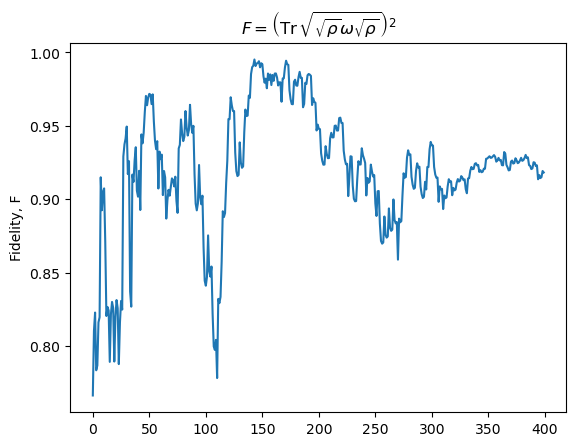

In [20]:
𝜔₁ = [1/2 0; 0 1/2]
𝜔 = []
push!(𝜔, 𝜔₁)

F = []

for t in 1:length(𝑌)
    𝜔ₜ = next_𝜔(𝜔, E, 𝑌)
    push!(𝜔, 𝜔ₜ)
    push!(F, fidelity(ρ, 𝜔ₜ))
end  


print("Final fidelity:", fidelity(ρ, 𝜔[end]))

plt = plot(F, label="")
plt = ylabel("Fidelity, F")
plt = title( latexstring(L"F = \left( \operatorname{Tr} \sqrt{\sqrt{\rho} \omega \sqrt{\rho}} \right)^2"))
show(plt)

In [21]:
𝜔[end]

2×2 Matrix{ComplexF64}:
 0.263706+0.0im        -0.43601-0.0589765im
 -0.43601+0.0589765im  0.736294+0.0im

In [22]:
ρ 

2×2 Hermitian{ComplexF64, Matrix{ComplexF64}}:
  0.409675+0.0im       -0.399063-0.128277im
 -0.399063+0.128277im   0.590325+0.0im

#### Try all together in one cell

Final fidelity:0.9884753196779218PyObject Text(0.5, 1.0, '$F = \\left( \\operatorname{Tr} \\sqrt{\\sqrt{\\rho} \\omega \\sqrt{\\rho}} \\right)^2$')

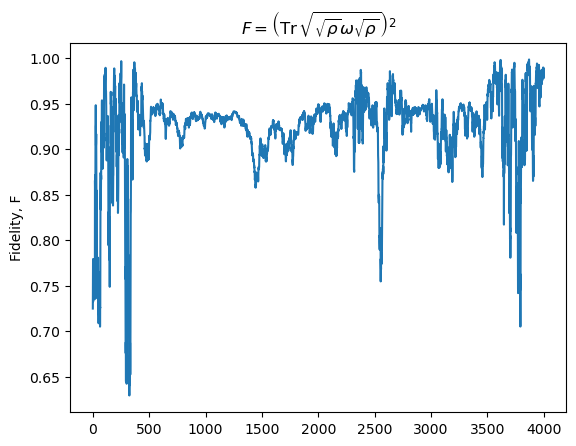

In [23]:
# Generate random density matrix
ρ = ρᵣₐₙ(2)

# Simulate POVM measurements

T = 1000 # number of measurements for each operator 

𝑌₁ₛ = rand(Bernoulli(abs(tr(E₁ₛ*ρ))), T)
𝑌₂ₛ = rand(Bernoulli(abs(tr(E₂ₛ*ρ))), T)
𝑌₃ₛ = rand(Bernoulli(abs(tr(E₃ₛ*ρ))), T)
𝑌₄ₛ = rand(Bernoulli(abs(tr(E₄ₛ*ρ))), T)

# Combine measurements into one sequence

E = []
𝑌 = []

for i in 1:T
    push!(E, E₁ₛ)
    push!(𝑌, 𝑌₁ₛ[i])
    
    push!(E, E₂ₛ) 
    push!(𝑌, 𝑌₂ₛ[i])

    push!(E, E₃ₛ)   
    push!(𝑌, 𝑌₃ₛ[i])

    push!(E, E₄ₛ)   
    push!(𝑌, 𝑌₄ₛ[i])

end

# Set initian guess

𝜔₁ = [1/2 0; 0 1/2]
𝜔 = []
push!(𝜔, 𝜔₁)

F = [] # empy list to store fidelity

# Main loop of approxiamtion 

for t in 1:length(𝑌)
    𝜔ₜ = next_𝜔(𝜔, E, 𝑌)
    push!(𝜔, 𝜔ₜ)
    push!(F, fidelity(ρ, 𝜔ₜ))
end  

# Results output

print("Final fidelity:", fidelity(ρ, 𝜔[end]))

plt = plot(F, label="")
plt = ylabel("Fidelity, F")
plt = title( latexstring(L"F = \left( \operatorname{Tr} \sqrt{\sqrt{\rho} \omega \sqrt{\rho}} \right)^2"))
show(plt)